In [1]:
import numpy as np 
import scanpy as sc 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
# adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/snrna_human_tonsil.h5ad')
# adata

adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes'
    uns: 'cell_thresholds', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count'

In [3]:
import sys
sys.path.append('../../src/')

import celloracle as co 


In [4]:
oracle = co.load_hdf5('/tmp/tonsil.celloracle.oracle')

In [5]:
links = co.load_hdf5("/tmp/links.celloracle.links")

In [6]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

  0%|          | 0/13 [00:00<?, ?it/s]

In [7]:
links.links_dict.keys()

dict_keys(['B_germinal_center', 'B_memory', 'B_naive', 'FDC', 'NK', 'T_CD4', 'T_CD8', 'T_double_neg', 'T_follicular_helper', 'mDC', 'myeloid', 'pDC', 'plasma'])

In [8]:
links.links_dict['B_germinal_center'].query('source == "FOXO1" and target == "CXCR4"')

,source,target,coef_mean,coef_abs,p,-logp
18008,FOXO1,CXCR4,0.071202,0.071202,1.112498e-13,12.953701


In [10]:
goi = 'FOXO1'
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=4)

In [11]:
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200, knn_random=True, sampled_fraction=1)

# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr = 0.05)

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline


### CO flipping dots

In [13]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [14]:
adata_ = adata[adata.obs['banksy_celltypes'].isin(['GC Intermediate Zone','GC Dark Zone','GC Light Zone'])]
adata_

View of AnnData object with n_obs × n_vars = 1743 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes'
    uns: 'cell_thresholds', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl', 'pca', 'neighbors', 'umap'
    obsm: 'spatial', 'spatial_unscaled', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count'
    obsp: 'distances', 'connectivities'

In [15]:
color_dict = {
    'CD4+ T': "#ea7465",
    'Tfh': "#b74329", 
    'CD8+ T': "#dd3652",
    'T cells': "#7a4711",
    'GC Intermediate Zone': "#e28723",
    'GC Dark Zone': "#147ee9",
    'GC Light Zone': "#f309c5",
    'GC B': "#6a064f",
    'B memory': "#61c17c",
    'B naive': "#4b9131", 
    'Plasma': "#beb637",
    'T memory': "#98907f",
}

import sys 
sys.path.append('../../src')
from spaceoracle.plotting.cartography import Cartography

In [16]:
chart = Cartography(adata_, color_dict)
chart.adata.obs['banksy_celltypes'].unique()

['GC Light Zone', 'GC Intermediate Zone', 'GC Dark Zone']
Categories (3, object): ['GC Dark Zone', 'GC Intermediate Zone', 'GC Light Zone']

In [17]:
# CellOracle
simulated_df = oracle.adata.to_df(layer='simulated_count').loc[adata_.obs.index]
method='CO'

In [18]:
co_P = pd.DataFrame(oracle.corrcoef, index=oracle.adata.obs.index, columns=oracle.adata.obs.index)
P = co_P.loc[adata_.obs.index, adata_.obs.index].values
P.sum()

2300.6910321557393

In [19]:
import alphashape
from matplotlib.legend_handler import HandlerTuple
import matplotlib
import seaborn as sns 
from shapely.geometry import Point

In [20]:
try:
    chart.adata.obs.drop(['transition'], axis=1, inplace=True)
except:
    pass

In [21]:
chart.get_transition_annot(
    P, 
    allowed_fates=chart.adata.obs['banksy_celltypes'].unique(), 
    thresh=0, 
    annot='banksy_celltypes'
)

100%|██████████| 726/726 [00:07<00:00, 98.69it/s] 


source ct GC Light Zone Counter({'GC Light Zone': 552, 'GC Intermediate Zone': 146, 'GC Dark Zone': 28}) 2.1857123026400297e-05 0.0


100%|██████████| 457/457 [00:04<00:00, 93.12it/s] 


source ct GC Intermediate Zone Counter({'GC Light Zone': 270, 'GC Intermediate Zone': 138, 'GC Dark Zone': 49}) 0.0006352445262215707 0.0


100%|██████████| 560/560 [00:05<00:00, 104.57it/s]

source ct GC Dark Zone Counter({'GC Intermediate Zone': 194, 'GC Dark Zone': 183, 'GC Light Zone': 183}) 0.0009285756162600894 0.0


In [22]:
xy = pd.DataFrame(adata.obsm['spatial'], index=adata.obs.index, columns=['x', 'y'])

In [23]:
adata.obs['x'] = adata.obsm['spatial'][:, 0]
adata.obs['y'] = adata.obsm['spatial'][:, 1]

In [24]:
ct_points_wt, ct_points_ko = chart.make_celltype_dict(annot='banksy_celltypes')

In [25]:
alpha_shape_0 = alphashape.alphashape(ct_points_ko['GC Intermediate Zone'], alpha=0.05)
alpha_shape_1 = alphashape.alphashape(ct_points_ko['GC Dark Zone'], alpha=0.05)
alpha_shape_2 = alphashape.alphashape(ct_points_ko['GC Light Zone'], alpha=0.05)

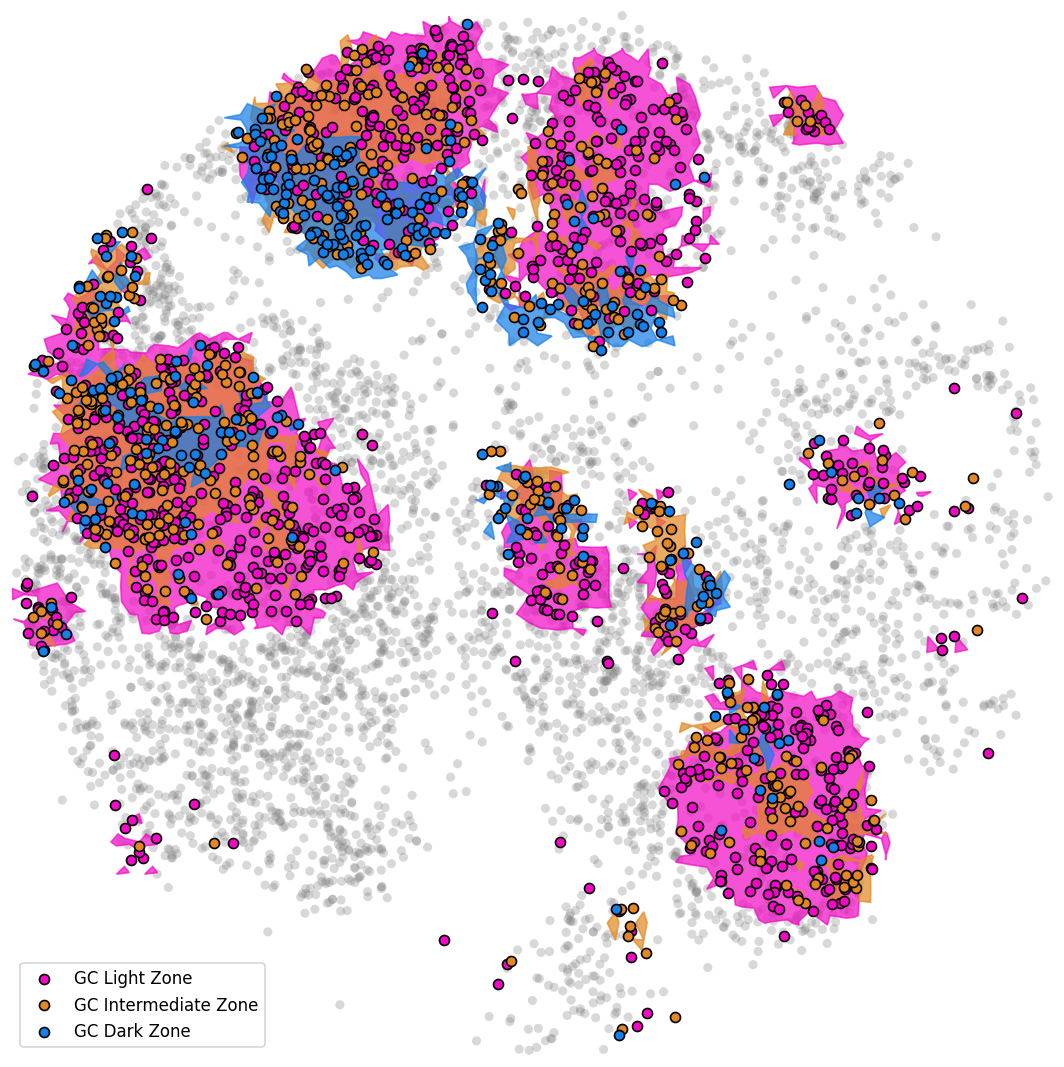

In [27]:
fig, ax = plt.subplots(figsize=(20, 9), dpi=120)

scatter = sns.scatterplot(
    data = adata.obs,
    x='x', y='y',
    color='grey',
    s=30,
    alpha=0.3,
    edgecolor='none',
    ax=ax,
)

zone_alpha = 0.7
area_thresh = 150

for cluster, alpha_shape in zip(['GC Light Zone', 'GC Intermediate Zone', 'GC Dark Zone'],
                                [alpha_shape_2, alpha_shape_0, alpha_shape_1]):
    try:
        for geom in alpha_shape.geoms:
            if geom.area > area_thresh:
                ax.fill(
                    geom.exterior.xy[0], 
                    geom.exterior.xy[1], 
                    color=color_dict[str(cluster)], alpha=zone_alpha)
    except:
        geom = alpha_shape
        ax.fill(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color=color_dict[str(cluster)], alpha=zone_alpha
        )

for ct in chart.adata.obs['transition'].unique():
    ax.scatter(
        chart.adata[chart.adata.obs['transition'] == ct].obsm['spatial'][:, 0],
        chart.adata[chart.adata.obs['transition'] == ct].obsm['spatial'][:, 1],
        c=color_dict[ct], alpha=1, edgecolor='black', linewidth=1,
        label=ct
    )

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_aspect('equal')
ax.set_xlim(adata.obs.x.min() - 10, adata.obs.x.max() + 10)
ax.set_ylim(adata.obs.y.min() - 10, adata.obs.y.max() + 10)
plt.tight_layout()

# plt.savefig(f'figures/human_tonsil_{goi}KO_postKO_{method}.svg', format='svg', bbox_inches='tight', transparent=True)

In [28]:
goi, method

('FOXO1', 'CO')

In [29]:
chart.adata.obs['transition'] = chart.adata.obs['transition'].astype('category')
chart.adata.obs['transition'] = chart.adata.obs['transition'].cat.remove_unused_categories()

chart.adata.obs['transition'].unique()

['GC Light Zone', 'GC Intermediate Zone', 'GC Dark Zone']
Categories (3, object): ['GC Dark Zone', 'GC Intermediate Zone', 'GC Light Zone']

In [30]:
df = chart.adata.obs[['banksy_celltypes', 'transition']].copy()
counts = df.groupby(['banksy_celltypes', 'transition']).size().unstack(fill_value=0)
counts

transition,GC Dark Zone,GC Intermediate Zone,GC Light Zone
banksy_celltypes,,,
GC Dark Zone,183,194,183
GC Intermediate Zone,49,138,270
GC Light Zone,28,146,552


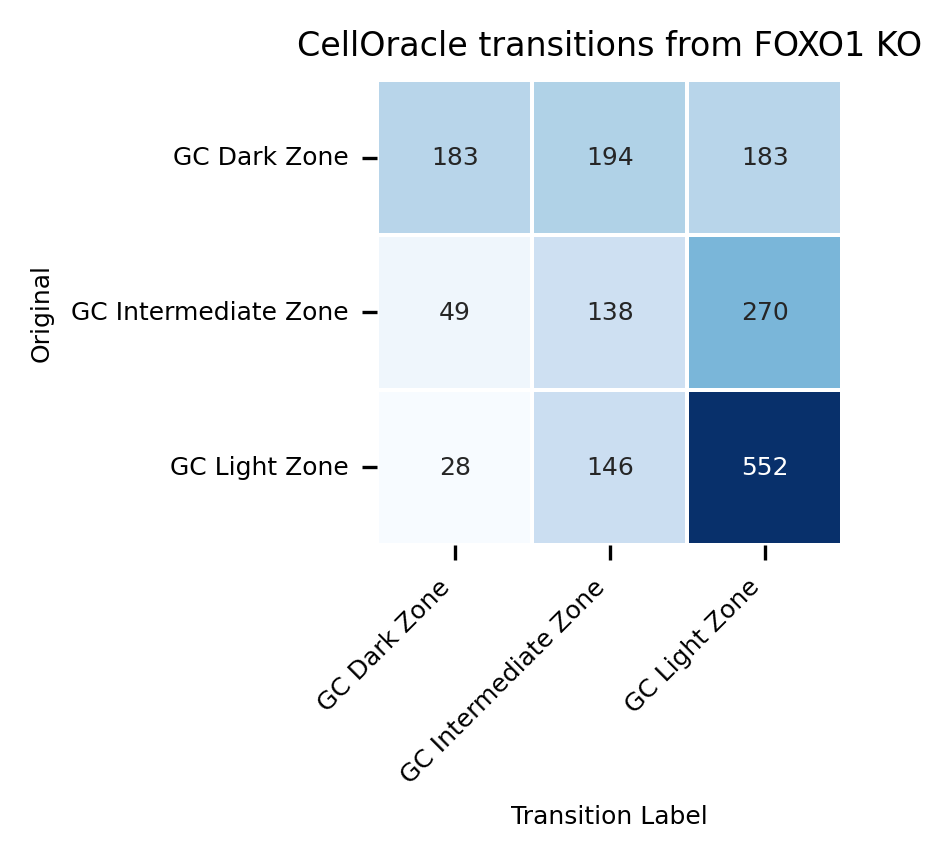

In [32]:
plt.figure(figsize=(3,3), dpi=300)

# Ensure counts has same number of rows and columns
if counts.empty:
    # Create empty DataFrame with same index and columns
    counts = pd.DataFrame(0, index=counts.index, columns=counts.columns)
elif len(counts.index) != len(counts.columns):
    # Add missing rows/columns with zeros
    all_labels = sorted(set(counts.index) | set(counts.columns))
    counts = counts.reindex(index=all_labels, columns=all_labels, fill_value=0)

sns.heatmap(
    counts,
    annot=True,
    fmt='d',  # Changed to integer format
    cmap='Blues',
    linewidths=0.5,
    linecolor='white',
    cbar=False,
    square=True,
    annot_kws={"size": 6}
)

plt.title(f"CellOracle transitions from {goi} KO", fontsize=8)
plt.xlabel("Transition Label", fontsize=6)
plt.ylabel("Original", fontsize=6)
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.yticks(rotation=0, fontsize=6)

plt.tight_layout()
# plt.savefig(f'figures/human_tonsil_{goi}KO_transitions_{method}.svg', 
            # format='svg', transparent=True, dpi=300, bbox_inches='tight')
plt.show()

### Create matching plots

In [148]:
# adata.obs['banksy_celltypes'].value_counts()

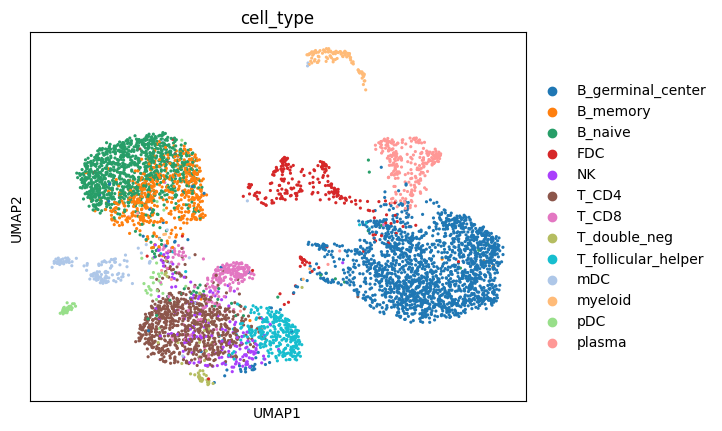

In [149]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.umap(adata)
sc.pl.umap(adata, color='cell_type')

In [150]:
color_dict = {
    'CD4+ T': "#ea7465",
    'Tfh': "#b74329", 
    'CD8+ T': "#dd3652",
    'T cells': "#7a4711",
    'GC Intermediate Zone': "#e28723",
    'GC Dark Zone': "#147ee9",
    'GC Light Zone': "#f309c5",
    'GC B': "#6a064f",
    'B memory': "#61c17c",
    'B naive': "#4b9131", 
    'Plasma': "#beb637",
    'T memory': "#98907f",
}

import sys 
sys.path.append('../../src')
from spaceoracle.plotting.cartography import Cartography




In [151]:
adata_ = adata[adata.obs['banksy_celltypes'].isin(['GC Intermediate Zone','GC Dark Zone','GC Light Zone'])]
adata_

View of AnnData object with n_obs × n_vars = 1743 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes', 'cell_type_2', 'x', 'y'
    uns: 'cell_thresholds', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl', 'pca', 'neighbors', 'draw_graph', 'diffmap_evals', 'paga', 'banksy_celltypes_sizes', 'banksy_celltypes_colors', 'umap', 'cell_type_colors'
    obsm: 'spatial', 'spatial_unscaled', 'X_pca', 'X_draw_graph_fa', 'X_diffmap', 'X_umap'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count'
    obsp: 'distances', 'connectivities'

In [152]:
adata.shape, adata_.shape

((5778, 3333), (1743, 3333))

In [232]:
chart = Cartography(adata_, color_dict)

In [233]:
goi = 'FOXO1'

# SpaceTravLR
simulated_df = pd.read_parquet(f'/ix/djishnu/shared/djishnu_kor11/genome_screens/human_tonsil/{goi}_4n_0x.parquet').loc[adata_.obs.index]
method = 'ST'

# # CellOracle
# simulated_df = oracle.adata.to_df(layer='simulated_count').loc[adata_.obs.index]
# method='CO'

In [234]:
delta_X = (simulated_df - chart.unperturbed_expression).values
gene_mtx = chart.unperturbed_expression.values
gene_mtx.shape, delta_X.shape

((1743, 3333), (1743, 3333))

In [235]:
embedding = adata_.obsm['X_umap']
P = chart.compute_transition_probabilities(delta_X, embedding, n_neighbors=adata_.n_obs)
P.shape

(1743, 1743)

In [236]:
import alphashape
from matplotlib.legend_handler import HandlerTuple
import matplotlib
import seaborn as sns 
from shapely.geometry import Point

In [237]:
chart.adata.obs['banksy_celltypes'].unique()

['GC Light Zone', 'GC Intermediate Zone', 'GC Dark Zone']
Categories (3, object): ['GC Dark Zone', 'GC Intermediate Zone', 'GC Light Zone']

In [238]:
try:
    chart.adata.obs.drop(['transition'], axis=1, inplace=True)
except:
    pass

In [239]:
chart.get_transition_annot(
    P, 
    allowed_fates=chart.adata.obs['banksy_celltypes'].unique(), 
    thresh=0, 
    annot='banksy_celltypes'
)

100%|██████████| 726/726 [00:09<00:00, 76.14it/s]


source ct GC Light Zone Counter({'GC Light Zone': 724, 'GC Intermediate Zone': 2}) 0.0003315607870127964 0.0


100%|██████████| 457/457 [00:05<00:00, 76.57it/s]


source ct GC Intermediate Zone Counter({'GC Light Zone': 457}) 0.00020551772070105125 0.0


100%|██████████| 560/560 [00:07<00:00, 76.78it/s]

source ct GC Dark Zone Counter({'GC Light Zone': 436, 'GC Intermediate Zone': 124}) 0.00029726195055962016 0.0


In [240]:
xy = pd.DataFrame(adata.obsm['spatial'], index=adata.obs.index, columns=['x', 'y'])

In [241]:
adata.obs['x'] = adata.obsm['spatial'][:, 0]
adata.obs['y'] = adata.obsm['spatial'][:, 1]

In [242]:
ct_points_wt, ct_points_ko = chart.make_celltype_dict(annot='banksy_celltypes')

In [243]:
alpha_shape_0 = alphashape.alphashape(ct_points_wt['GC Intermediate Zone'], alpha=0.05)
alpha_shape_1 = alphashape.alphashape(ct_points_wt['GC Dark Zone'], alpha=0.05)
alpha_shape_2 = alphashape.alphashape(ct_points_wt['GC Light Zone'], alpha=0.05)

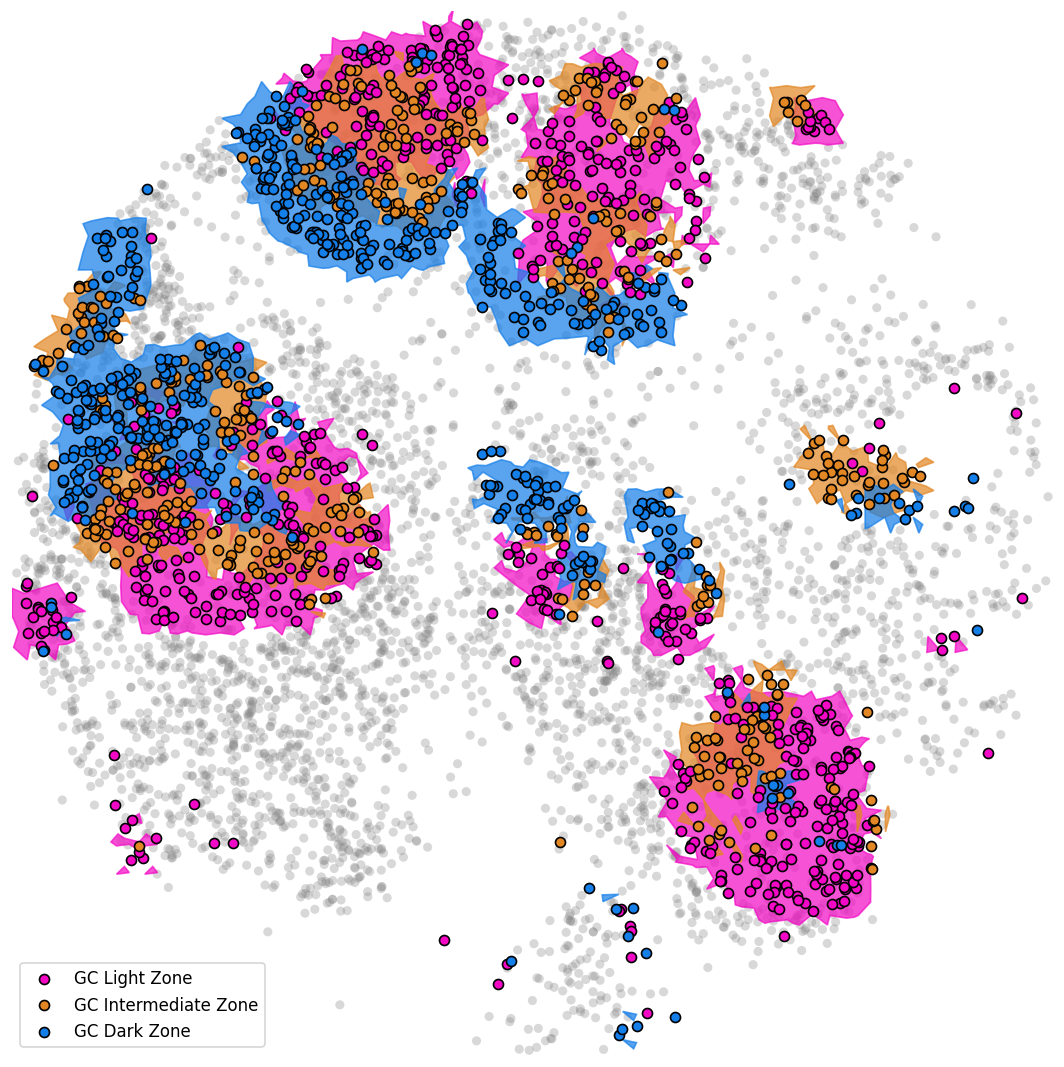

In [244]:
fig, ax = plt.subplots(figsize=(20, 9), dpi=120)

scatter = sns.scatterplot(
    data = adata.obs,
    x='x', y='y',
    color='grey',
    s=30,
    alpha=0.3,
    edgecolor='none',
    ax=ax,
)

zone_alpha = 0.7
area_thresh = 150

for cluster, alpha_shape in zip(['GC Light Zone', 'GC Intermediate Zone', 'GC Dark Zone'],
                                [alpha_shape_2, alpha_shape_0, alpha_shape_1]):
    try:
        for geom in alpha_shape.geoms:
            if geom.area > area_thresh:
                ax.fill(
                    geom.exterior.xy[0], 
                    geom.exterior.xy[1], 
                    color=color_dict[str(cluster)], alpha=zone_alpha)
    except:
        geom = alpha_shape
        ax.fill(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color=color_dict[str(cluster)], alpha=zone_alpha
        )

for ct in chart.adata.obs['banksy_celltypes'].unique():
    ax.scatter(
        adata[adata.obs['banksy_celltypes'] == ct].obsm['spatial'][:, 0],
        adata[adata.obs['banksy_celltypes'] == ct].obsm['spatial'][:, 1],
        c=color_dict[ct], alpha=1, edgecolor='black', linewidth=1,
        label=ct
    )

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_aspect('equal')
ax.set_xlim(adata.obs.x.min() - 10, adata.obs.x.max() + 10)
ax.set_ylim(adata.obs.y.min() - 10, adata.obs.y.max() + 10)
plt.tight_layout()

plt.savefig(f'figures/human_tonsil_{goi}KO_preKO_{method}.svg', format='svg', bbox_inches='tight', transparent=True)

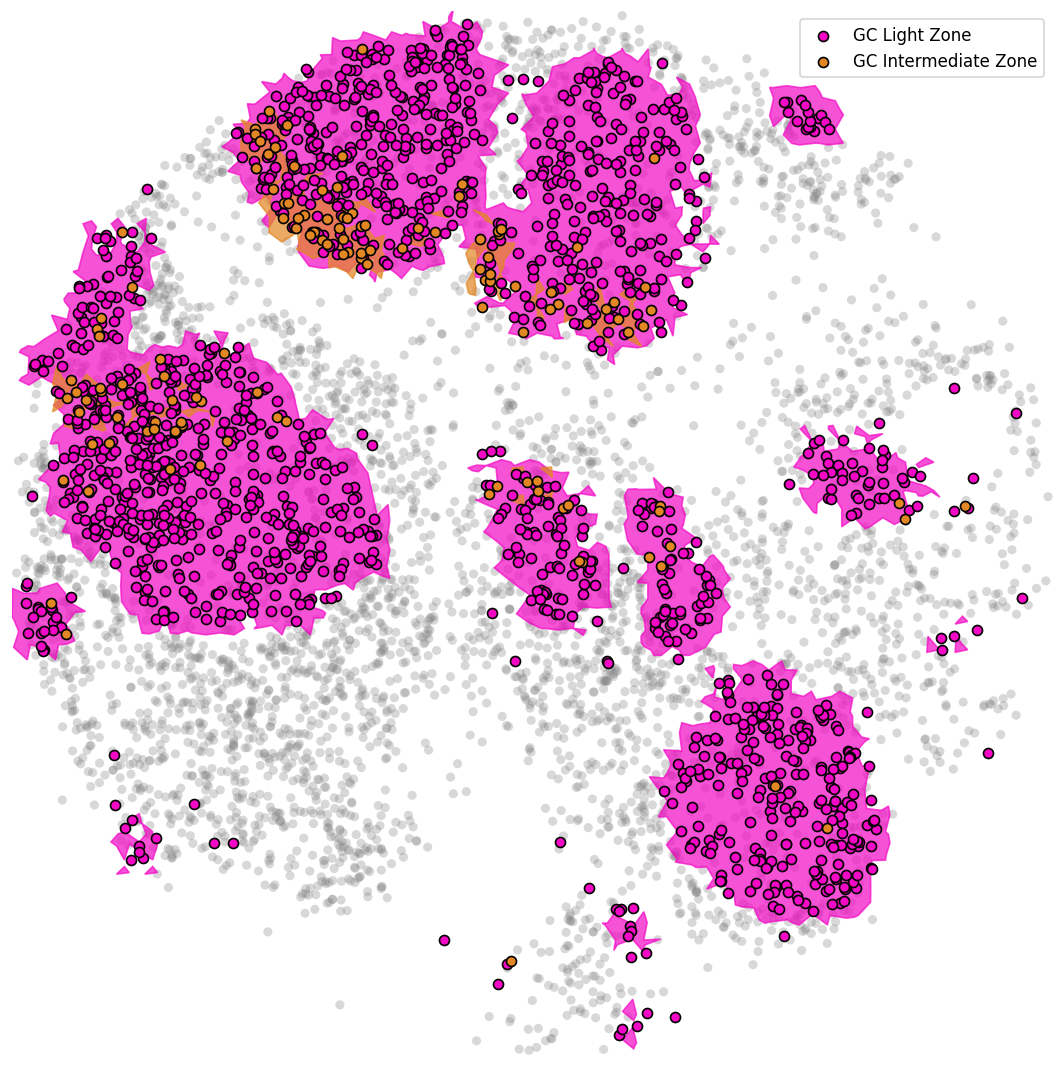

In [245]:
alpha_shape_0 = alphashape.alphashape(ct_points_ko['GC Intermediate Zone'], alpha=0.05)
try:
    alpha_shape_1 = alphashape.alphashape(ct_points_ko['GC Dark Zone'], alpha=0.05)
except:
    alpha_shape_1 = None
alpha_shape_2 = alphashape.alphashape(ct_points_ko['GC Light Zone'], alpha=0.05)

fig, ax = plt.subplots(figsize=(20, 9), dpi=120)

scatter = sns.scatterplot(
    data = adata.obs,
    x='x', y='y',
    color='grey',
    s=30,
    alpha=0.3,
    edgecolor='none',
    ax=ax,
)

zone_alpha = 0.7
area_thresh = 150

for cluster, alpha_shape in zip(['GC Light Zone', 'GC Intermediate Zone', 'GC Dark Zone'],
                                [alpha_shape_2, alpha_shape_0, alpha_shape_1]):
    if alpha_shape is None:
        continue
    try:
        for geom in alpha_shape.geoms:
            if geom.area > area_thresh:
                ax.fill(
                    geom.exterior.xy[0], 
                    geom.exterior.xy[1], 
                    color=color_dict[str(cluster)], alpha=zone_alpha)
    except:
        geom = alpha_shape
        ax.fill(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color=color_dict[str(cluster)], alpha=zone_alpha
        )

for ct in chart.adata.obs['transition'].unique():
    ax.scatter(
        chart.adata[chart.adata.obs['transition'] == ct].obsm['spatial'][:, 0],
        chart.adata[chart.adata.obs['transition'] == ct].obsm['spatial'][:, 1],
        c=color_dict[ct], alpha=1, edgecolor='black', linewidth=1,
        label=ct
    )

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_aspect('equal')
ax.set_xlim(adata.obs.x.min() - 10, adata.obs.x.max() + 10)
ax.set_ylim(adata.obs.y.min() - 10, adata.obs.y.max() + 10)
plt.tight_layout()

plt.savefig(f'figures/human_tonsil_{goi}KO_postKO_{method}.svg',
            format='svg', transparent=True, dpi=300, bbox_inches='tight')

In [246]:
# adata = chart.adata
chart.adata.obs['leiden'] = adata.obs['banksy_celltypes']

In [247]:
chart.adata.obs['leiden'] = chart.adata.obs['leiden'].cat.remove_unused_categories()
chart.adata.obs['transition'] = chart.adata.obs['transition'].astype('category')
chart.adata.obs['transition'] = chart.adata.obs['transition'].cat.remove_unused_categories()

In [248]:
df = chart.adata.obs[['leiden', 'transition']].copy()
counts = df.groupby(['leiden', 'transition']).size().unstack(fill_value=0)

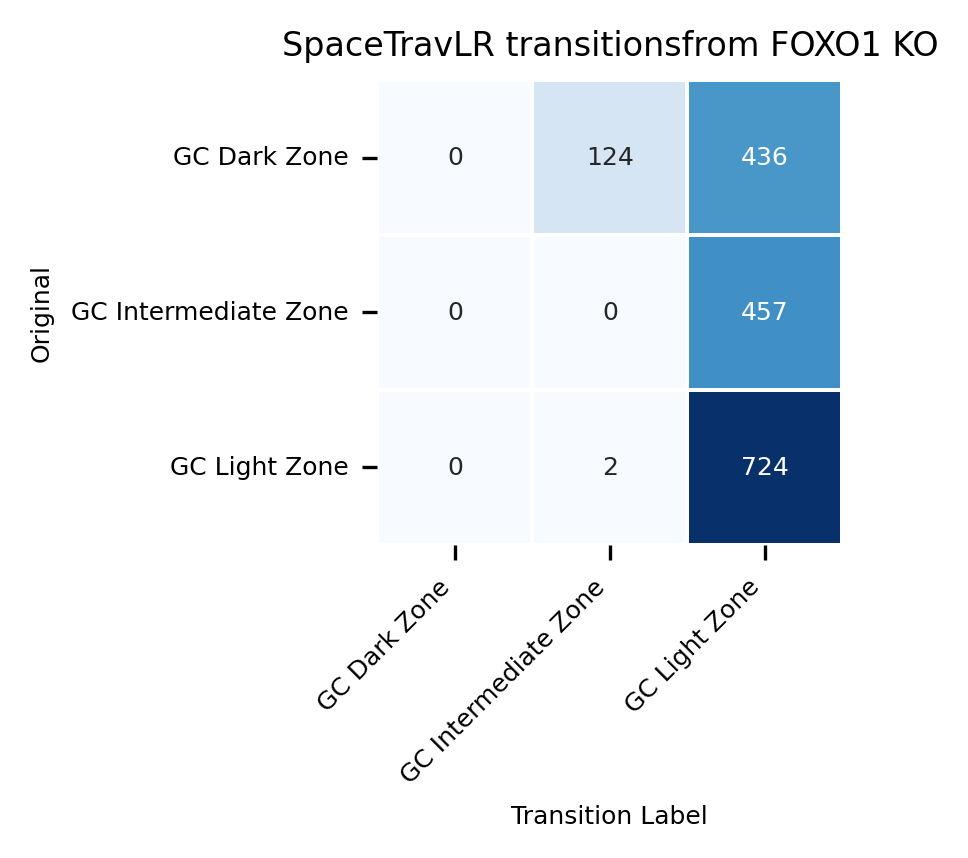

In [249]:
plt.figure(figsize=(3,3), dpi=300)

# Ensure counts has same number of rows and columns
if counts.empty:
    # Create empty DataFrame with same index and columns
    counts = pd.DataFrame(0, index=counts.index, columns=counts.columns)
elif len(counts.index) != len(counts.columns):
    # Add missing rows/columns with zeros
    all_labels = sorted(set(counts.index) | set(counts.columns))
    counts = counts.reindex(index=all_labels, columns=all_labels, fill_value=0)

sns.heatmap(
    counts,
    annot=True,
    fmt='d',  # Changed to integer format
    cmap='Blues',
    linewidths=0.5,
    linecolor='white',
    cbar=False,
    square=True,
    annot_kws={"size": 6}
)

plt.title(f"SpaceTravLR transitionsfrom {goi} KO", fontsize=8)
plt.xlabel("Transition Label", fontsize=6)
plt.ylabel("Original", fontsize=6)
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.yticks(rotation=0, fontsize=6)

plt.tight_layout()
plt.savefig(f'figures/human_tonsil_{goi}KO_transitions_{method}.svg', 
            format='svg', transparent=True, dpi=300, bbox_inches='tight')
plt.show()